# Movies Reviews Sentiment Model Using BERT and Serving it with Flask API
![](https://i.imgur.com/15srONs.png?1 )
**Image: Flask App Screenshot**

# Introduction

My goal for this project was learn how to build and deploy a production-grade movies reviews sentiment model using BERT model serving it with Flask API. Users are able to send text to the model, via an API, and get back predictions on local server. 
#### Dataset
I have used [large movie review dataset](https://ai.stanford.edu/~amaas/data/sentiment/), this is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided.

#### Bert Model
[BERT (Bidirectional Encoder Representations from Transformers)](https://arxiv.org/pdf/1810.04805.pdf) is a recent paper published by researchers at Google AI Language. It has caused a stir in the Machine Learning community by presenting state-of-the-art results in a wide variety of NLP tasks, including Question Answering (SQuAD v1.1), Natural Language Inference (MNLI), and others.

BERT’s key technical innovation is applying the bidirectional training of Transformer, a popular attention model, to language modelling. This is in contrast to previous efforts which looked at a text sequence either from left to right or combined left-to-right and right-to-left training. The paper’s results show that a language model which is bidirectionally trained can have a deeper sense of language context and flow than single-direction language models. In the paper, the researchers detail a novel technique named Masked LM (MLM) which allows bidirectional training in models in which it was previously impossible.

#### BERT Fine-Tuning With PyTorch
I'll use BERT with the huggingface PyTorch library to quickly and efficiently fine-tune a model to get near state of the art performance in sentence classification. More broadly, I describe the practical application of transfer learning in NLP to create high performance models with minimal effort on a range of NLP tasks. Specifically, we will take the pre-trained BERT model, add an untrained layer of neurons on the end, and train the new model for our classification task.

# Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
import os
import transformers
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn import model_selection
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import logging
logging.getLogger().setLevel(logging.NOTSET)

# Configuration

In [2]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 3
BERT_PATH = "../input/bert-base-uncased"
MODEL_PATH = "model.bin"
TRAINING_FILE = "../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv"
TOKENIZER = transformers.BertTokenizer.from_pretrained(BERT_PATH, do_lower_case=True)

# Data Exploration

In [3]:
"""Reading dataset"""
df = pd.read_csv(TRAINING_FILE)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
"Data Dresription"
print('Shape of the dataset', df.shape)
print('Missing values')
print(df.isnull().sum())

Shape of the dataset (50000, 2)
Missing values
review       0
sentiment    0
dtype: int64


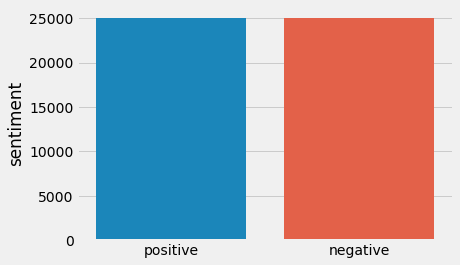

In [5]:
"""Distribution of target variable"""
temp = df["sentiment"].value_counts()
sns.barplot(temp.index, temp)
plt.show()

Target distribution is perfectly balanced.

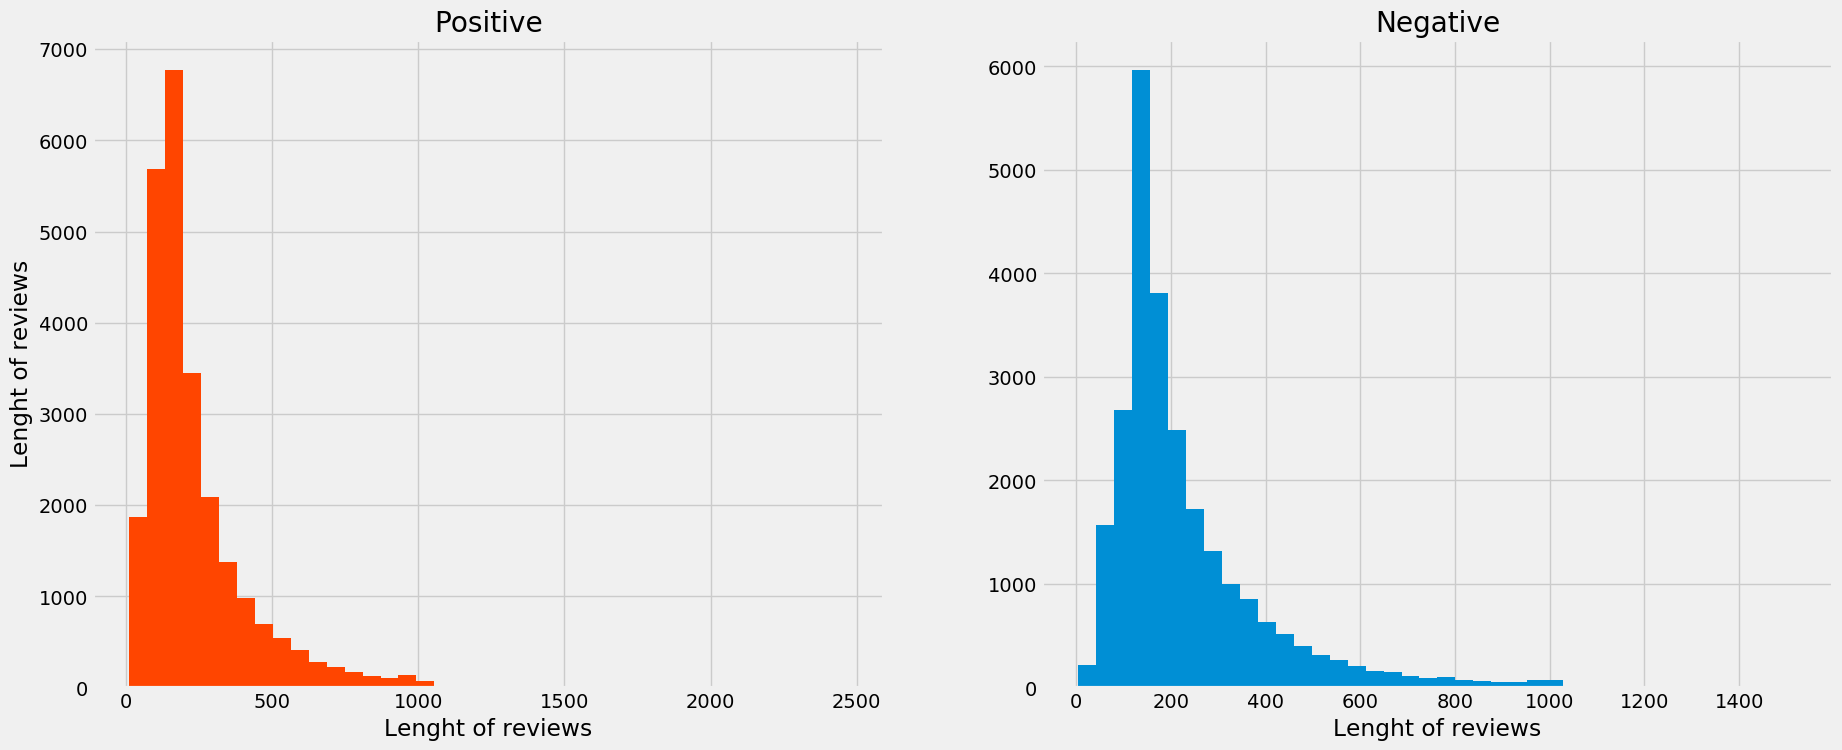

In [6]:
'''Plot sentence lenght'''
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(20, 8), dpi=100)
num=df[df["sentiment"]=='positive']['review'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 40,color='orangered')
ax1.set_title('Positive')
ax1.set_xlabel('Lenght of reviews')
num=df[df["sentiment"]=='negative']['review'].str.split().map(lambda x: len(x))
ax2.hist(num,bins = 40)
ax2.set_title('Negative')
ax2.set_xlabel('Lenght of reviews')
ax1.set_ylabel('Lenght of reviews')
plt.show()

# Build and Train the Model

In [7]:
class BERTDataset:
    '''
    We are required to give it a number of pieces of information which seem redundant, 
    or like they could easily be inferred from the data without us explicity providing it.
    This class prepare the dataset or input format to BERT modeling.
    '''
    def __init__(self, review, target):
        self.review = review
        self.target = target
        self.tokenizer = TOKENIZER
        self.max_len = MAX_LEN
    
    def __len__(self):
        return len(self.review)
    
    def __getitem__(self, item):
        review = str(self.review[item])
        review = " ".join(review.split())

        inputs = self.tokenizer.encode_plus(
            review,                         # sentence to encode
            None,
            add_special_tokens=True,        # add '[CLS]' and '[SEP]'
            max_length=self.max_len,        # pad & truncate all sentences.
            pad_to_max_length=True
        )
        
        # Map the tokens to thier word ids, mask and attention_mask
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        
        # Return pytorch tensors
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.target[item], dtype=torch.float)
        }

In [8]:
class BERTBaseUncased(nn.Module):
    '''
    we'll be using BERT Model. This class we feed the bert input data, the entire pre-trained
    BERT model and the additional untrained classification layer is trained on our specific task.
    '''
    def __init__(self):
        super(BERTBaseUncased, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(BERT_PATH)
        self.bert_drop = nn.Dropout(0.3)    # define the dropout
        self.out = nn.Linear(768, 1)        # fully connected linear layer

    def forward(self, ids, mask, token_type_ids):
        # Perform a forward pass. Feeding the inputs in the bert model
        _, o2 = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        bo = self.bert_drop(o2)     # performing dropout on  output vector
        output = self.out(bo)       # performing fully connected linear layer on output vector
        return output 


In [9]:
total_train_loss = 0
total_eval_loss = 0

# define the binary_cross_entropy loss function
def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))

# define the trainging function
def train_fn(data_loader, model, optimizer, device, scheduler):
    global total_train_loss 
    
    # Set the model to training mode
    model.train()
    # trange is a tqdm wrapper around the normal python range
    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
         # Unpack training batch from our dataloader.
        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        targets = d["targets"]
        
        # copy each tensor to the GPU
        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)
        
        # clear any previously calculated gradients
        optimizer.zero_grad()
        # outputs prior to activation.
        outputs = model(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )

        loss = loss_fn(outputs, targets)    # Perform a loss funtion
        total_train_loss += loss.item()     # Accumulate the training loss
        loss.backward()                     # Perform a backward pass to calculate the gradients
        optimizer.step()                    # Update parameters
        scheduler.step()                    # Update the learning rate
        
        
        
        
# define the validation function
def eval_fn(data_loader, model, device):
    global total_eval_loss
    model.eval()            # Set the model to training mode
    fin_targets = []        # target variable
    fin_outputs = []        # ouput variable
    
    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():
        # trange is a tqdm wrapper around the normal python range
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            # Unpack validation batch from our dataloader.
            ids = d["ids"]
            token_type_ids = d["token_type_ids"]
            mask = d["mask"]
            targets = d["targets"]
            
            # copy each tensor to the GPU
            ids = ids.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)
            
            # outputs prior to activation.
            outputs = model(
                ids=ids,
                mask=mask,
                token_type_ids=token_type_ids
            )
            
            loss = loss_fn(outputs, targets)        # Perform a loss funtion
            total_eval_loss += loss.item()          # Accumulate the validation loss.
            
            # Move target and output to CPU
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [10]:
device = torch.device("cuda")     # define the device
model = BERTBaseUncased()         # define the model
model.to(device)                  # copy the model to the gpu

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [11]:
 training_stats = []
    
# running script funtion
def run():
    print('==== Training And Validation ==== ')
     # Load the dataset into a pandas dataframe.
    dfx = pd.read_csv(TRAINING_FILE).fillna("none")
    dfx.sentiment = dfx.sentiment.apply(lambda x: 1 if x == "positive" else 0)
    
    # split up our traing set to use 90% for training and 10% for validation
    df_train, df_valid = model_selection.train_test_split(
        dfx, test_size=0.1, random_state=42, stratify=dfx.sentiment.values
    )
    
    df_train = df_train.reset_index(drop=True)
    df_valid = df_valid.reset_index(drop=True)
    
    # pass the sentence and target from training dataset into class
    train_dataset = BERTDataset(
        review=df_train.review.values, target=df_train.sentiment.values
    )
    
    # Combine the training inputs into a TensorDataset.
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=TRAIN_BATCH_SIZE, num_workers=4
    )
    
    # pass the sentence and target from training dataset into class
    valid_dataset = BERTDataset(
        review=df_valid.review.values, target=df_valid.sentiment.values
    )
    
    # Combine the training inputs into a TensorDataset.
    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=VALID_BATCH_SIZE, num_workers=4
    )

    
    # Prepare optimizer and schedule (linear warmup and decay)
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [
                p for n,p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.01,
        },
        {
            "params": [p for n,p in param_optimizer if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    
    # Create the numer of training steps, optimizer and scheduler
    num_train_steps = int(len(df_train) / TRAIN_BATCH_SIZE * EPOCHS)
    optimizer = AdamW(optimizer_parameters, lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )
    
    # running the loop for every epochs
    # Tracking variables 
    best_accuracy = 0
    for epoch in range(EPOCHS):
        
        # passing training and validation funtion
        train_fn(train_data_loader, model, optimizer, device, scheduler)
        outputs, targets = eval_fn(valid_data_loader, model, device)
        outputs = np.array(outputs) >= 0.5
        
        # Calculate the average train loss
        avg_train_loss = total_train_loss / len(train_data_loader)
        
        # Calculate the average valid loss
        avg_val_loss = total_eval_loss / len(valid_data_loader)
        
        # Calculate the validation accuracy for test sentences
        eval_accuracy = metrics.accuracy_score(targets, outputs)
        
        # Report the final accuracy for this validation run.
        print(f"Validation Accuracy Score {eval_accuracy}")
        
        training_stats.append(
            {
                'epoch': epoch + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
            }
        )
        
        # saving the model
        if eval_accuracy > best_accuracy:
            torch.save(model.state_dict(), MODEL_PATH)
            best_accuracy = eval_accuracy


if __name__ == "__main__":
    run()

==== Training And Validation ==== 


100%|██████████| 1250/1250 [01:38<00:00, 12.73it/s]


Validation Accuracy Score 0.9402


100%|██████████| 1250/1250 [01:37<00:00, 12.88it/s]


Validation Accuracy Score 0.9434


100%|██████████| 1250/1250 [01:36<00:00, 12.94it/s]


Validation Accuracy Score 0.9514


In [12]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss
epoch,,
1,0.21,0.15
2,0.29,0.31
3,0.33,0.49


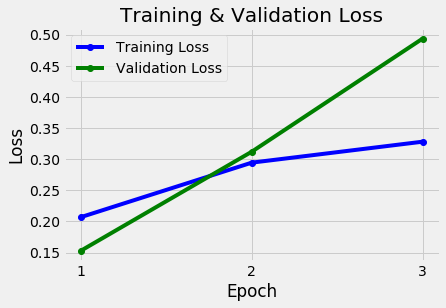

In [13]:
# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training Loss")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation Loss")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1,2,3])
plt.show()

## References
- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805),
- [Training Sentiment Model Using BERT and Serving it with Flask API](https://www.youtube.com/watch?v=hinZO--TEk4&t=448s),
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM),
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/),
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/),
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)",
- [Huggingface Transformers](https://huggingface.co/transformers/),
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)